# Introduction to atomman: Volterra dislocation models

__Lucas M. Hale__, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), _Materials Science and Engineering Division, NIST_.
    
[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm) 

## 1. Introduction

This Notebook provides an introduction to the tools in atomman for computing elasticity solutions for straight Volterra dislocations.

- atomman.defect.solve_volterra_dislocation() is a wrapper function that returns one of the two classes below based on the supplied elastic constants.

- atomman.defect.IsotropicVolterraDislocation class uses the classical analytical equations associated with the isotropic straight dislocation.

- atomman.defect.Stroh class solves the Eshelby anisotropic straight dislocation problem using the Stroh (eigenvector) method.

Both calculation classes are children of the atomman.defect.VolterraDislocation template class, and therefore provide a similar interface for initialization and obtaining evaluated properties. 

**Library Imports**

In [1]:
# Standard libraries
import os
import datetime
from copy import deepcopy

# http://www.numpy.org/
import numpy as np     
np.set_printoptions(precision=3)

import matplotlib.pyplot as plt
%matplotlib inline

# https://github.com/usnistgov/atomman
import atomman as am
import atomman.unitconvert as uc

# Show atomman version
print('atomman version =', am.__version__)

# Show date of Notebook execution
print('Notebook executed on', datetime.date.today())

atomman version = 1.3.0
Notebook executed on 2019-11-05


## 2. Theory

Dislocation theory is based on computing and using elasticity solutions of dislocations to define what they look like and how they interact with the surrounding material. The Volterra dislocation model assumes that the discontinuity in the crystal due to the dislocation exists as a line singularity. While this assumption does not hold true in real materials, the Volterra solution is still a good estimate far from the dislocation core. It also provides a useful starting point for developing more complicated dislocation solutions, and can provide a decent initial guess for constructing atomic dislocation configurations.

For straight dislocations, the solutions are always defined relative to three orthogonal unit vectors $m_i$, $n_i$, and $\xi_i$ 

- $m_i$ is the direction in the slip plane perpendicular to the line direction.

- $n_i$ is the normal of the dislocation's slip plane.

- $\xi_i$ is parallel to the dislocation's line direction.

Based on these three vectors, we can define a Cartesian coordinate system for the dislocation solution with positions, $x_i$, 
given by

$$ x_i = x_1 m_i + x_2 n_i + x_3 \xi_i $$ 




### 2.1 Isotropic solution

Analytical equations for the isotropic dislocation solution can be found in nearly every textbook focused on dislocation theory.  The equations used in atomman are close to those found in Elementary Dislocation Theory by Weertman and Weertman, except with flipped signs. 

Isotropic elastic constants can be represented using only two independent terms. For dislocation solutions, the two isotropic elastic constants typically used are the shear modulus, $\mu$, and the Poisson's ratio, $\nu$. 

With a straight dislocation, the solution is independent of the $x_3$ direction and therefore only depends on $x_1$ and $x_2$. 

The specific isotropic equations used here were selected such that values and periods compare well with the Stroh results.

### 2.2 Basics of the Stroh method

Starting with the fundamental equations of elasticity:

$$ \sigma_{ij} = C_{ijkl} \epsilon_{kl} $$

$$ \epsilon_{ij} = \frac{1}{2} \left(\frac{\partial u_i}{\partial x_j} + \frac{\partial u_j}{\partial x_i}\right) $$

$$ \frac{\partial \sigma_{ij}}{\partial x_j} = 0 $$

Combining these and taking the solution to be independent of $x_3$ generates the partial differential equation:

$$ C_{ijkl} \frac{ \partial^2 u_k}{\partial x_j \partial x_l} = 0 $$

Solutions of the partial differential equation are of the form 

$$ u_k = A_k f(x_1 + p x_2) $$

Values of $A_k$ and $p$ can be found by solving

$$ \left[C_{i1k1} + \left(C_{i1k2} + C_{i2k1} \right) p + C_{i2k2} p^2 \right] A_k = 0 $$

The determinate expression is a sixth-order polynomial expression resulting in six complex roots, $p_\alpha$ with $\alpha$ ranging 1 to 6. There is also one $A_{k \alpha}$ corresponding to each root.

With the Stroh method for solving the problem, another vector, $L_i$ is defined for each $\alpha$ root as

$$ L_{i \alpha} = \left(C_{i2k1} + p_{\alpha} C_{i2k2} \right) A_{k \alpha} $$

and a normalization factor, $k_{\alpha}$, as

$$ k_{\alpha} = \frac{1}{2 A_{j \alpha} L_{j \alpha}} $$

Stroh's method is then to write the problem as an eigenvector problem, which solving gives values for $p_{\alpha}$, $A_{i \alpha}$, and $L_{i \alpha}$.  Properties of the dislocation can then be computed with equations that use these solution parameters.

## 3. Initialize/solve

A Volterra dislocation solution can be obtained by either calling the solve_volterra_dislocation() function, or by initializing one of the dislocation solution classes. The two classes also have a solve() method that allows for a new solution to be obtained using the same object. The solve_volterra_dislocation() function, the class initializers, and the class solve methods all accept the same set of parameters.

Parameters

- **C** (*atomman.ElasticConstants*) The medium's elastic constants.

- **burgers** (*array-like object*) The dislocation's Cartesian Burgers vector.

- **axes** (*array-like object, optional*) 3x3 set of rotational axes for the system. If given, C and burgers will be transformed using axes.

- **m** (*array-like object, optional*) The m Cartesian unit vector for the solution giving the $x_1$ direction.  m, n, and $\xi$ (dislocation line direction) should be right-hand orthogonal.  Default value is [1,0,0] (Cartesian x-axis).

- **n** (*array-like object, optional*) The n Cartesian unit vector for the solution giving the $x_2$ direction.  m, n, and $\xi$ (dislocation line direction) should be right-hand orthogonal.  Default value is [0,1,0] (Cartesian y-axis).

- **tol** (*float*) Tolerance parameter used to round off near-zero values.  Default value is 1e-8.

### 3.1 Fcc dislocation parameters

These are parameters for the fcc $\frac{a}{2}<10\bar{1}>{111}$ edge dislocation using the default $m=[100]$, $n=[010]$ orientation.  __Note__: alternate orientations may be preferred based on the matrix material's crystal structure and the simulation software that will be used. See Section #6 for discussion on more general cases.


In [2]:
# Cu fcc lattice constant
alat = uc.set_in_units(3.6, 'angstrom')

# burgers = a/2 <1 0 -1>
burgers = alat * np.array([0.5, 0, -0.5])

# Define system orientation axes for edge dislocation:
# xaxis aligned with m, i.e. edge component
# yaxis aligned with n, i.e. slip plane normal
# zaxis aligned with ξ, i.e. screw component
xaxis = [ 1, 0,-1]
yaxis = [ 1, 1, 1]
zaxis = [ 1,-2, 1]

### 3.2 Isotropic example

In [3]:
# Rough isotropic values for Cu
E = uc.set_in_units(130, 'GPa')
Poisson = 0.34

# Build ElasticConstants object (standard crystal reference)
C_iso = am.ElasticConstants(E=E, nu=Poisson)

# Solve dislocation
iso = am.defect.solve_volterra_dislocation(C_iso, burgers, axes=[xaxis, yaxis, zaxis])

Show class and solution parameters

In [4]:
print('iso is:')
print(iso)
print(f'iso.mu -> {uc.get_in_units(iso.mu, "GPa"):.3f} GPa')
print(f'iso.nu -> {iso.nu}')

iso is:
iso.mu -> 48.507 GPa
iso.nu -> 0.34


### 3.3 Anisotropic example

In [5]:
# Rough anisotropic values for Cu
C11 = uc.set_in_units(169, 'GPa')
C12 = uc.set_in_units(122, 'GPa')
C44 = uc.set_in_units(75.4, 'GPa')

# Build ElasticConstants object (standard crystal reference)
C_aniso = am.ElasticConstants(C11=C11, C12=C12, C44=C44)

# Solve Stroh method for conditions
aniso = am.defect.solve_volterra_dislocation(C_aniso, burgers, axes=[xaxis, yaxis, zaxis])

Show class and solution parameters

In [6]:
print('aniso is:')
print(aniso)
print()

print('aniso.p ->')
print(aniso.p)
print()

print('aniso.A ->')
print(aniso.A)
print()

print('aniso.L ->')
print(aniso.L)
print()

print('aniso.k ->')
print(aniso.L)
print()

aniso is:

aniso.p ->
[-5.743e-01+1.481j -5.743e-01-1.481j  5.743e-01+1.481j  5.743e-01-1.481j
  4.930e-32+0.394j  4.930e-32-0.394j]

aniso.A ->
[[-4.925e-01+2.927e-01j -1.867e-01-9.776e-02j  6.672e-01+0.000e+00j]
 [-4.925e-01-2.927e-01j -1.867e-01+9.776e-02j  6.672e-01-0.000e+00j]
 [ 4.925e-01+2.927e-01j -1.867e-01+9.776e-02j  6.672e-01+0.000e+00j]
 [ 4.925e-01-2.927e-01j -1.867e-01-9.776e-02j  6.672e-01-0.000e+00j]
 [ 3.134e-16-1.473e-01j  7.891e-01+0.000e+00j  4.278e-01-1.446e-16j]
 [ 3.134e-16+1.473e-01j  7.891e-01-0.000e+00j  4.278e-01+1.446e-16j]]

aniso.L ->
[[ 1.878e-01+2.534e-01j -1.060e-01+1.679e-01j  2.238e-02-2.069e-01j]
 [ 1.878e-01-2.534e-01j -1.060e-01-1.679e-01j  2.238e-02+2.069e-01j]
 [ 1.878e-01-2.534e-01j  1.060e-01+1.679e-01j -2.238e-02-2.069e-01j]
 [ 1.878e-01+2.534e-01j  1.060e-01-1.679e-01j -2.238e-02+2.069e-01j]
 [-1.504e-01-8.063e-17j  5.417e-17-3.818e-01j -8.178e-17-6.540e-02j]
 [-1.504e-01+8.063e-17j  5.417e-17+3.818e-01j -8.178e-17+6.540e-02j]]

aniso.k ->
[

## 4. Derived properties

Different properties of the solution can be derived from the solution parameters and obtained as other attributes of the class.

### 4.1 Energy coefficient tensor, K_tensor

The energy coefficient tensor is a property of the solution that is useful for dislocation stress and energy calculations. It only depends on the elastic constants and the orientation.

**Caution**: $K_{ij}$ is defined differently by different authors and may vary by multiplicative factors. Here, it is taken such that the isotropic screw component is the shear modulus, $\mu$.

#### 4.1.1 Isotropic

In the isotropic case, the only non-zero components (in the dislocation orientation) are

$$K_{11}^{iso} = K_{22}^{iso} = K_{edge}^{iso} = \frac{\mu}{1 - \nu}$$
$$K_{33}^{iso} = K_{screw}^{iso} = \mu$$

#### 4.1.2 Anisotropic

The tensor can be obtained from the Stroh solution parameters as

$$ K_{jl} = i \sum_{\alpha} \pm k_{\alpha} L_{j \alpha} L_{l \alpha} $$

where $i$ is the imaginary unit and the $\pm$ sense alternates for even/odd values of $\alpha$ (the six partial solutions are three pairs of complex conjugates).


In [7]:
print('iso.K_tensor (in GPa) ->')
print(uc.get_in_units(iso.K_tensor, 'GPa'))
print()
print('aniso.K_tensor (in GPa) ->')
print(uc.get_in_units(aniso.K_tensor, 'GPa'))

iso.K_tensor (in GPa) ->
[[73.496  0.     0.   ]
 [ 0.    73.496  0.   ]
 [ 0.     0.    48.507]]

aniso.K_tensor (in GPa) ->
[[74.096  0.     0.   ]
 [ 0.    74.933 -8.628]
 [ 0.    -8.628 44.217]]


### 4.2 Energy coefficient, K_coeff

The energy coefficient, $K$, is a dislocation-specific coefficient found in expressions for a dislocation's self-energy

$$\frac{W}{l} = \frac{K b^2}{4 \pi} \ln{ \left( \frac{R}{r_0} \right)}, $$

where $b$ is the magnitude of $b_i$, and $r_0$ and $R$ are the inner and outer radii of a cylindircal ring around the dislocation. The energy coefficient can be computed from the energy coefficent tensor and burgers vector

$$ K = \frac{b_i K_{ij} b_j} {b_k b_k} $$



In [8]:
# Note values are same as K11 component above due to pure edge dislocation
print(f'iso.K_coeff ->   {uc.get_in_units(iso.K_coeff, "GPa"):.3f} GPa')
print(f'aniso.K_coeff -> {uc.get_in_units(aniso.K_coeff, "GPa"):.3f} GPa')

iso.K_coeff ->   73.496 GPa
aniso.K_coeff -> 74.096 GPa


### 4.3 Pre-logarithmic factor, preln

Alternatively, the self-energy expression can be represented as

$$\frac{W}{l} = a \ln{ \left( \frac{R}{r_0} \right)}, $$

where $a$ is referred to as the pre-logarithmic energy factor and is in units of energy/length. Related to $K$ and $K_{ij}$,

$$ a = \frac{b_i K_{ij} b_j}{4 \pi} = \frac{K b^2}{4 \pi} $$

In [9]:
print(f'iso.preln ->   {uc.get_in_units(iso.preln, "eV/Å"):f} eV/Å')
print(f'aniso.preln -> {uc.get_in_units(aniso.preln, "eV/Å"):f} eV/Å')

iso.preln ->   0.236548 eV/Å
aniso.preln -> 0.238480 eV/Å


## 5. Position-dependent calculations

### 5.1. Setup

Create an fcc Cu demonstration unit cell

In [10]:
box = am.Box(a=alat, b=alat, c=alat)

atoms = am.Atoms(pos=[[0.0,0.0,0.0], [0.5,0.5,0.0], [0.5,0.0,0.5], [0.0,0.5,0.5]])

ucell = am.System(box=box,
                  atoms=atoms, 
                  scale=True)
print(ucell)

avect =  [ 3.600,  0.000,  0.000]
bvect =  [ 0.000,  3.600,  0.000]
cvect =  [ 0.000,  0.000,  3.600]
origin = [ 0.000,  0.000,  0.000]
natoms = 4
natypes = 1
symbols = (None,)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000
      1 |       1 |   1.800 |   1.800 |   0.000
      2 |       1 |   1.800 |   0.000 |   1.800
      3 |       1 |   0.000 |   1.800 |   1.800


Use ucell to generate system

In [11]:
# Create system by rotating ucell to coincide with dislocation solution
system = ucell.rotate([xaxis, yaxis, zaxis])

# Shift all atomic positions by half {111} planar spacing to avoid atoms at y=0
system.atoms.pos += alat * np.array([0.0, 3**0.5 / 6, 0.0])
system.wrap()

# Note equal +- mults along avect, bvect directions
system = system.supersize((-3,3), (-3,3), 1)

print('system.natoms ->', system.natoms)

system.natoms -> 864


Plot xy cross section of atoms

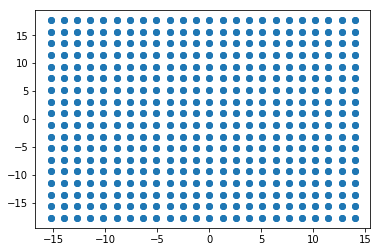

In [12]:
# plot original positions of atoms in system
plt.plot(system.atoms.pos[:, 0], system.atoms.pos[:, 1], 'o')
plt.show()

### 5.2 Derrived coordinates

The computed properties using both methods rely on derrived coordinates.  For validation/verification, these derrived coordinates can be directly retrieved.

#### 5.2.1 IsotropicVolterraDislocation.theta()

Certain properties of the isotropic dislocation are better represented in radial coordinates rather than Cartesian coordinates.  In particular, the isotropic equations used here depend on the radial angle coordinate, $\theta$

$$\theta=\tan^{-1} (x_2/x_1),$$

which is taken to range from $-\pi$ to $\pi$.

In [13]:
# Compute theta for all pos and show min/max values
theta = iso.theta(system.atoms.pos)
print(f'min(theta) -> {np.min(theta):f}')
print(f'max(theta) -> {np.max(theta):f}')

min(theta) -> -3.073656
max(theta) -> 3.073656


#### 5.2.2 Stroh.eta()

The position-dependent Stroh properties rely on an imaginary coordinate $\eta$ that combines $x_1$ and $x_2$ using the computed eigenvalues $p_{\alpha}$

$$ \eta_{\alpha} = x_1 + p_{\alpha} x_2 $$

In [14]:
# Compute eta for test position [1, 2, 3]
print('aniso.eta([1,2,3]) (in Å) ->')
print(uc.get_in_units(aniso.eta([1,2,3]), 'Å'))

aniso.eta([1,2,3]) (in Å) ->
[[-0.149+2.961j -0.149-2.961j  2.149+2.961j  2.149-2.961j  1.   +0.788j
   1.   -0.788j]]


### 5.3 displacements

Position-based displacements associated with the elastic solution can be calculated using either model. These can be applied to atomic configurations to generate "initial" dislocation configurations.

#### 5.3.1 Isotropic equations

$$ u_1 = \frac{b_1}{2 \pi} \left[ \theta + \frac{x_1x_2}{2 (1 - \nu) (x_1^2 + x_2^2)} \right]$$

$$ u_2 = \frac{b_1}{2 \pi} \left[ -\frac{1 - 2 \nu} {4 (1 - \nu)} \ln(x_1^2 + x_2^2)
                           + \frac{y^2} {2 (1 - \nu) (x^2 + y^2)} \right]$$

$$ u_3 = \frac{b_3}{2 \pi} \theta$$

#### 5.3.2 Anisotropic equations

$$ u_j = \frac{1}{2 \pi i} \sum_{\alpha}  \pm k_{\alpha} A_{j \alpha} (L_{l \alpha} b_l) \ln{\eta_{\alpha}} $$

Select the solution to use here and below

In [15]:
solution = aniso

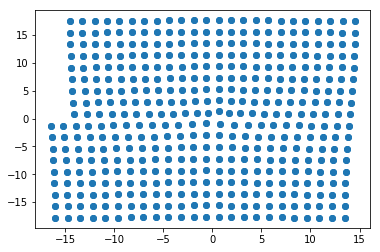

In [16]:
# Compute displacements for all positions
disp = solution.displacement(system.atoms.pos)

# Apply displacements to positions
system.atoms.pos += disp

# plot new positions of atoms in system
plt.plot(system.atoms.pos[:, 0], system.atoms.pos[:, 1], 'o')
plt.show()

### 5.3 stress

The stress state associated with the elastic solution can also be calculated at a given position for both models

#### 5.3.1 Isotropic equations

$$ \sigma_{11} = -\frac{\mu b_1}{2 \pi (1 - \nu)} \frac{x_2 (3 x_1^2 + x_2^2)} { (x_1^2 + x_2^2)^2}$$

$$ \sigma_{22} = \frac{\mu b_1}{2 \pi (1 - \nu)} \frac{x_2 (x_1^2 - x_2^2)} { (x_1^2 + x_2^2)^2}$$

$$ \sigma_{33} = \nu(\sigma_{11} + \sigma_{22})$$

$$ \sigma_{12} = \frac{\mu b_1}{2 \pi (1 - \nu)} \frac{x_1(x_1^2 - x_2^2)) }{ (x_1^2 + x_2^2)^2}$$

$$ \sigma_{13} =-\frac{\mu b_3}{2 \pi} \frac{x_2}{(x_1^2 + x_2^2)} $$

$$ \sigma_{23} = \frac{\mu b_3}{2 \pi} \frac{x_1}{(x_1^2 + x_2^2)} $$

#### 5.3.2 Anisotropic equations

$$ \sigma_{ij} = \frac{1}{2 \pi i} \sum_{\alpha}  \pm k_{\alpha} C_{ijkl}[m_l + p_{\alpha} n_l] A_{k \alpha} (L_{m \alpha} b_m) \frac{1}{\eta_{\alpha}} $$

In [17]:
# Calculate stress state at each atomic position
system.atoms.stress = solution.stress(system.atoms.pos)

stress_11:


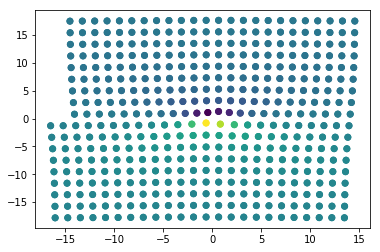

stress_22:


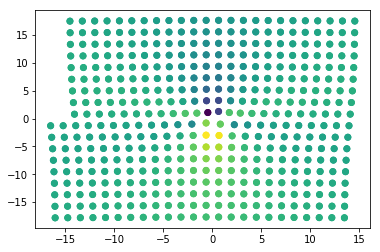

stress_33:


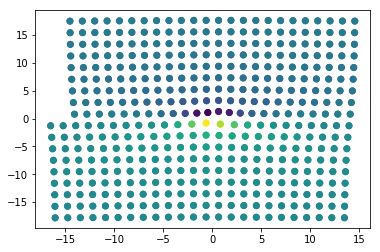

stress_12:


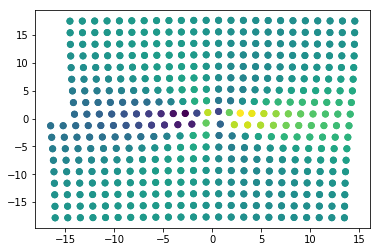

stress_13:


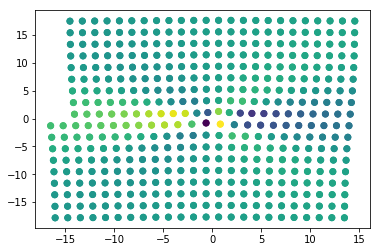

stress_23:


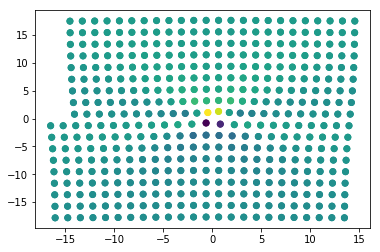

In [18]:
# Dirty plots of stress components
print('stress_11:')
plt.scatter(system.atoms.pos[:, 0], system.atoms.pos[:, 1], c=system.atoms.stress[:, 0, 0])
plt.show()

print('stress_22:')
plt.scatter(system.atoms.pos[:, 0], system.atoms.pos[:, 1], c=system.atoms.stress[:, 1, 1])
plt.show()

print('stress_33:')
plt.scatter(system.atoms.pos[:, 0], system.atoms.pos[:, 1], c=system.atoms.stress[:, 2, 2])
plt.show()

print('stress_12:')
plt.scatter(system.atoms.pos[:, 0], system.atoms.pos[:, 1], c=system.atoms.stress[:, 0, 1])
plt.show()

print('stress_13:')
plt.scatter(system.atoms.pos[:, 0], system.atoms.pos[:, 1], c=system.atoms.stress[:, 0, 2])
plt.show()

print('stress_23:')
plt.scatter(system.atoms.pos[:, 0], system.atoms.pos[:, 1], c=system.atoms.stress[:, 1, 2])
plt.show()

## 6. General case considerations

Properly building atomistic systems with dislocations using the Stroh method requires careful considerations regarding the system orientation.  This is complicated by the need to think in terms of multiple axes systems

- $[hkl]$ crystal vectors are commonly used to define dislocation types and slip planes.  These vectors are taken relative to the box vectors of a unit cell in a standard reference frame.

- The atomistic system's orientation is defined by specifying $[hkl]$ crystal vectors to coincide with the system's $a_i$, $b_i$, $c_i$ box vectors.

- The atomic positions within the atomistic system are represented with Cartesian $x'_i$ coordinates.

- The elastic solution is defined for Cartesian $x_i$ coordinates, where $x_2$ is normal to the slip plane and $x_3$ is parallel to the dislocation line.

As the latter two are both Cartesian, $x_i$ values are easily obtained from $x'_i$ using transformation unit vectors $m_i$ and $n_i$

- $x_1 = m_i x'_i$

- $x_2 = n_i x'_i$

- $x_3$ values not needed as the elastic solution is invariant in that direction.

Depending on the crystal structure and dislocation type, it is not always possible to construct a system with orthogonal box vectors.  This means that the $a_i$, $b_i$, $c_i$ box vectors will not necessarily align with the $x'_i$ axes.  For this general case, the following requirements and choices can help with orientation decisions

- The dislocation's line direction must be parallel to one of the box vectors for the dislocation to remain infinitely straight.

- For convenience, each of the elastic solution's $x_i$-axes should map to one of the atomic system's $x'_i$-axes.  This is accomplished if both the dislocation line and the slip plane normal are oriented along $x'_i$-axes.

With LAMMPS-compatible system boxes

- The $a_i$ box vector is always aligned with the $x'_1$-axis, therefore the dislocation line should be parallel to the $a_i$ vector / $x'_1$-axis.

- The $a_i$ and $b_i$ box vectors have no component in the $x'_3$ direction, i.e. the plane containing both $a_i$ and $b_i$ is normal to the $x'_3$-axis.  The slip plane normal can then be taken as parallel to the $x'_3$-axis.

- Related to the elastic solution, this makes $x_1$ parallel to the $x'_2$-axis, $x_2$ parallel to the $x'_3$-axis, and $x_3$ parallel to the $x'_1$-axis. The corresponding $m_i$ and $n_i$ values are

    - $m_i = [0, 1, 0]$
    
    - $n_i = [0, 0, 1]$

Redefine earlier problem, but in LAMMPS-preferred setting for general dislocations

In [19]:
# Set m, n vectors
m = [0,1,0]
n = [0,0,1]
 
# Define system orientation axes for edge dislocation:
# xaxis aligned with ξ, i.e. screw component
# yaxis aligned with m, i.e. edge component
# zaxis aligned with n, i.e. slip plane normal
xaxis = [ 1,-2, 1]
yaxis = [ 1, 0,-1]
zaxis = [ 1, 1, 1]

# Get iso and aniso solutions for new orientation
iso = am.defect.solve_volterra_dislocation(C_iso, burgers, axes=[xaxis, yaxis, zaxis], m=m, n=n)
aniso = am.defect.solve_volterra_dislocation(C_aniso, burgers, axes=[xaxis, yaxis, zaxis], m=m, n=n)

Check that derived values are consistent (K_tensor rotated)

In [20]:
print('iso.K_tensor (in GPa) ->')
print(uc.get_in_units(iso.K_tensor, 'GPa'))
print()

print('aniso.K_tensor (in GPa) ->')
print(uc.get_in_units(aniso.K_tensor, 'GPa'))
print()

print(f'iso.K_coeff ->   {uc.get_in_units(iso.K_coeff, "GPa"):.3f} GPa')
print(f'aniso.K_coeff -> {uc.get_in_units(aniso.K_coeff, "GPa"):.3f} GPa')
print()

# preln is considered in units of energy/length
print(f'iso.preln ->   {uc.get_in_units(iso.preln, "eV/Å"):f} eV/Å')
print(f'aniso.preln -> {uc.get_in_units(aniso.preln, "eV/Å"):f} eV/Å')

iso.K_tensor (in GPa) ->
[[48.507  0.     0.   ]
 [ 0.    73.496  0.   ]
 [ 0.     0.    73.496]]

aniso.K_tensor (in GPa) ->
[[44.217  0.    -8.628]
 [ 0.    74.096  0.   ]
 [-8.628  0.    74.933]]

iso.K_coeff ->   73.496 GPa
aniso.K_coeff -> 74.096 GPa

iso.preln ->   0.236548 eV/Å
aniso.preln -> 0.238480 eV/Å


Generate an atomic system that is properly rotated as well

In [21]:
# Create system by rotating ucell to coincide with dislocation solution
system = ucell.rotate([xaxis, yaxis, zaxis])

# Shift all atomic positions so y=0 and z=0 are between atomic planes
system.atoms.pos += alat * np.array([0.0, 2**0.5 / 8, 3**0.5 / 6])
system.wrap()

# Note equal +- mults along avect, bvect directions
system = system.supersize(1, (-3,3), (-3,3))

print('system.natoms ->', system.natoms)

system.natoms -> 864


Show that resulting displacements are the same as above, just with plotting y, z coordinates instead of x, y coordinates.

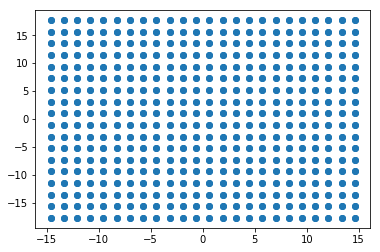

In [22]:
# plot original positions of atoms in system
plt.plot(system.atoms.pos[:, 1], system.atoms.pos[:, 2], 'o')
plt.show()

In [23]:
solution = iso

stress_11:


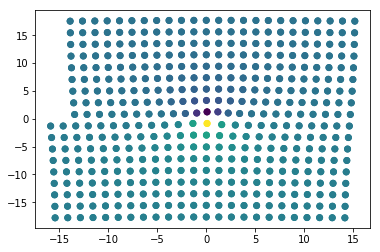

In [24]:
# Compute displacements for all positions
disp = solution.displacement(system.atoms.pos)

# Apply displacements to positions
system.atoms.pos += disp

# Calculate stress state at each atomic position
system.atoms.stress = solution.stress(system.atoms.pos)

# Dirty plots of displaced atoms and stress component
print('stress_11:')
plt.scatter(system.atoms.pos[:, 1], system.atoms.pos[:, 2], c=system.atoms.stress[:, 0, 0])
plt.show()